<a href="https://colab.research.google.com/github/mykolesiko/MILTestTasks/blob/master/layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir("/content/drive/MyDrive/MADE/work/mil_team/")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F
import glob
#import segmentation_models_pytorch as smp

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
import cv2

import torchvision
import torch.optim as optim
import torchvision.models as models
from tqdm.notebook import tqdm
from torch.nn import functional as fnn

import pandas as pd
import PIL
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
import skimage.io as io

In [4]:
def set_global_seed(seed: int) -> None:
    """Sets random seed into Numpy and Random, PyTorch and TensorFlow.
    Args:
        seed: random seed
    """
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True    

    try:
        import torch_xla.core.xla_model as xm
    except ImportError:
        pass
    else:
        xm.set_rng_state(seed)

In [5]:
set_global_seed(1)

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [7]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 16
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=1e-3
    self.learning_rate_gamma=None
    self.image_size = 256
    self.weight_bce=0.5
    self.load=None
    self.gpu = True
    self.output_dir="/content/drive/MyDrive/MADE/Project/RACNN_models/"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

In [8]:
!unzip dataset.zip -d /content/datadir

Archive:  dataset.zip
   creating: /content/datadir/data/
  inflating: /content/datadir/data/PMC1247515_00004.jpg  
  inflating: /content/datadir/data/PMC1247608_00001.jpg  
  inflating: /content/datadir/data/PMC1247661_00005.jpg  
  inflating: /content/datadir/data/PMC1253666_00004.jpg  
  inflating: /content/datadir/data/PMC1253757_00003.jpg  
  inflating: /content/datadir/data/PMC1257601_00005.jpg  
  inflating: /content/datadir/data/PMC1257646_00001.jpg  
  inflating: /content/datadir/data/PMC1278484_00004.jpg  
  inflating: /content/datadir/data/PMC1280404_00007.jpg  
  inflating: /content/datadir/data/PMC1281266_00005.jpg  
  inflating: /content/datadir/data/PMC1310923_00004.jpg  
  inflating: /content/datadir/data/PMC1314913_00001.jpg  
  inflating: /content/datadir/data/PMC1314918_00004.jpg  
  inflating: /content/datadir/data/PMC1332664_00003.jpg  
  inflating: /content/datadir/data/PMC1343590_00003.jpg  
  inflating: /content/datadir/data/PMC2040133_00002.jpg  
  inflating: /

In [9]:
!pip install pycocotools

In [10]:
from pycocotools.coco import COCO
coco=COCO("/content/datadir/train.json")

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [11]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
text figure



In [12]:
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO supercategories: 



In [13]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['text','figure']);
imgIds = coco.getImgIds(catIds=catIds );
#imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [14]:
os.chdir("/content/datadir/data/")

(794, 596, 3)


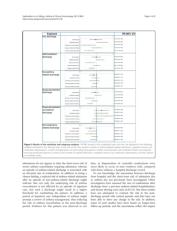

In [15]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['file_name'])
print(I.shape)
plt.axis('off')
plt.imshow(I)
plt.show()

In [16]:
print(img)

{'file_name': 'PMC3880050_00005.jpg', 'width': 596, 'id': 372844, 'height': 794}


[{'segmentation': [[0.511275167785235, 0.7159949622166247, 0.9035906040268455, 0.7159949622166247, 0.9035906040268455, 0.7311335012594459, 0.9036744966442953, 0.7311335012594459, 0.9036744966442953, 0.744874055415617, 0.8448657718120806, 0.744874055415617, 0.8448657718120806, 0.7599370277078086, 0.511275167785235, 0.7599370277078086, 0.511275167785235, 0.7461964735516373, 0.511275167785235, 0.7311335012594459, 0.511275167785235, 0.7159949622166247]], 'area': 7741.443669785978, 'iscrowd': 0, 'image_id': 372844, 'bbox': [0.511275167785235, 0.7159949622166247, 0.3923825503355705, 0.043954659949622166], 'category_id': 1, 'id': 3634000}, {'segmentation': [[0.09511744966442953, 0.7159949622166247, 0.4873993288590604, 0.7159949622166247, 0.4873993288590604, 0.7311335012594459, 0.48760067114093963, 0.7311335012594459, 0.48760067114093963, 0.7461964735516373, 0.48761744966442955, 0.7461964735516373, 0.48761744966442955, 0.7599496221662468, 0.4873657718120806, 0.7599496221662468, 0.4873657718120

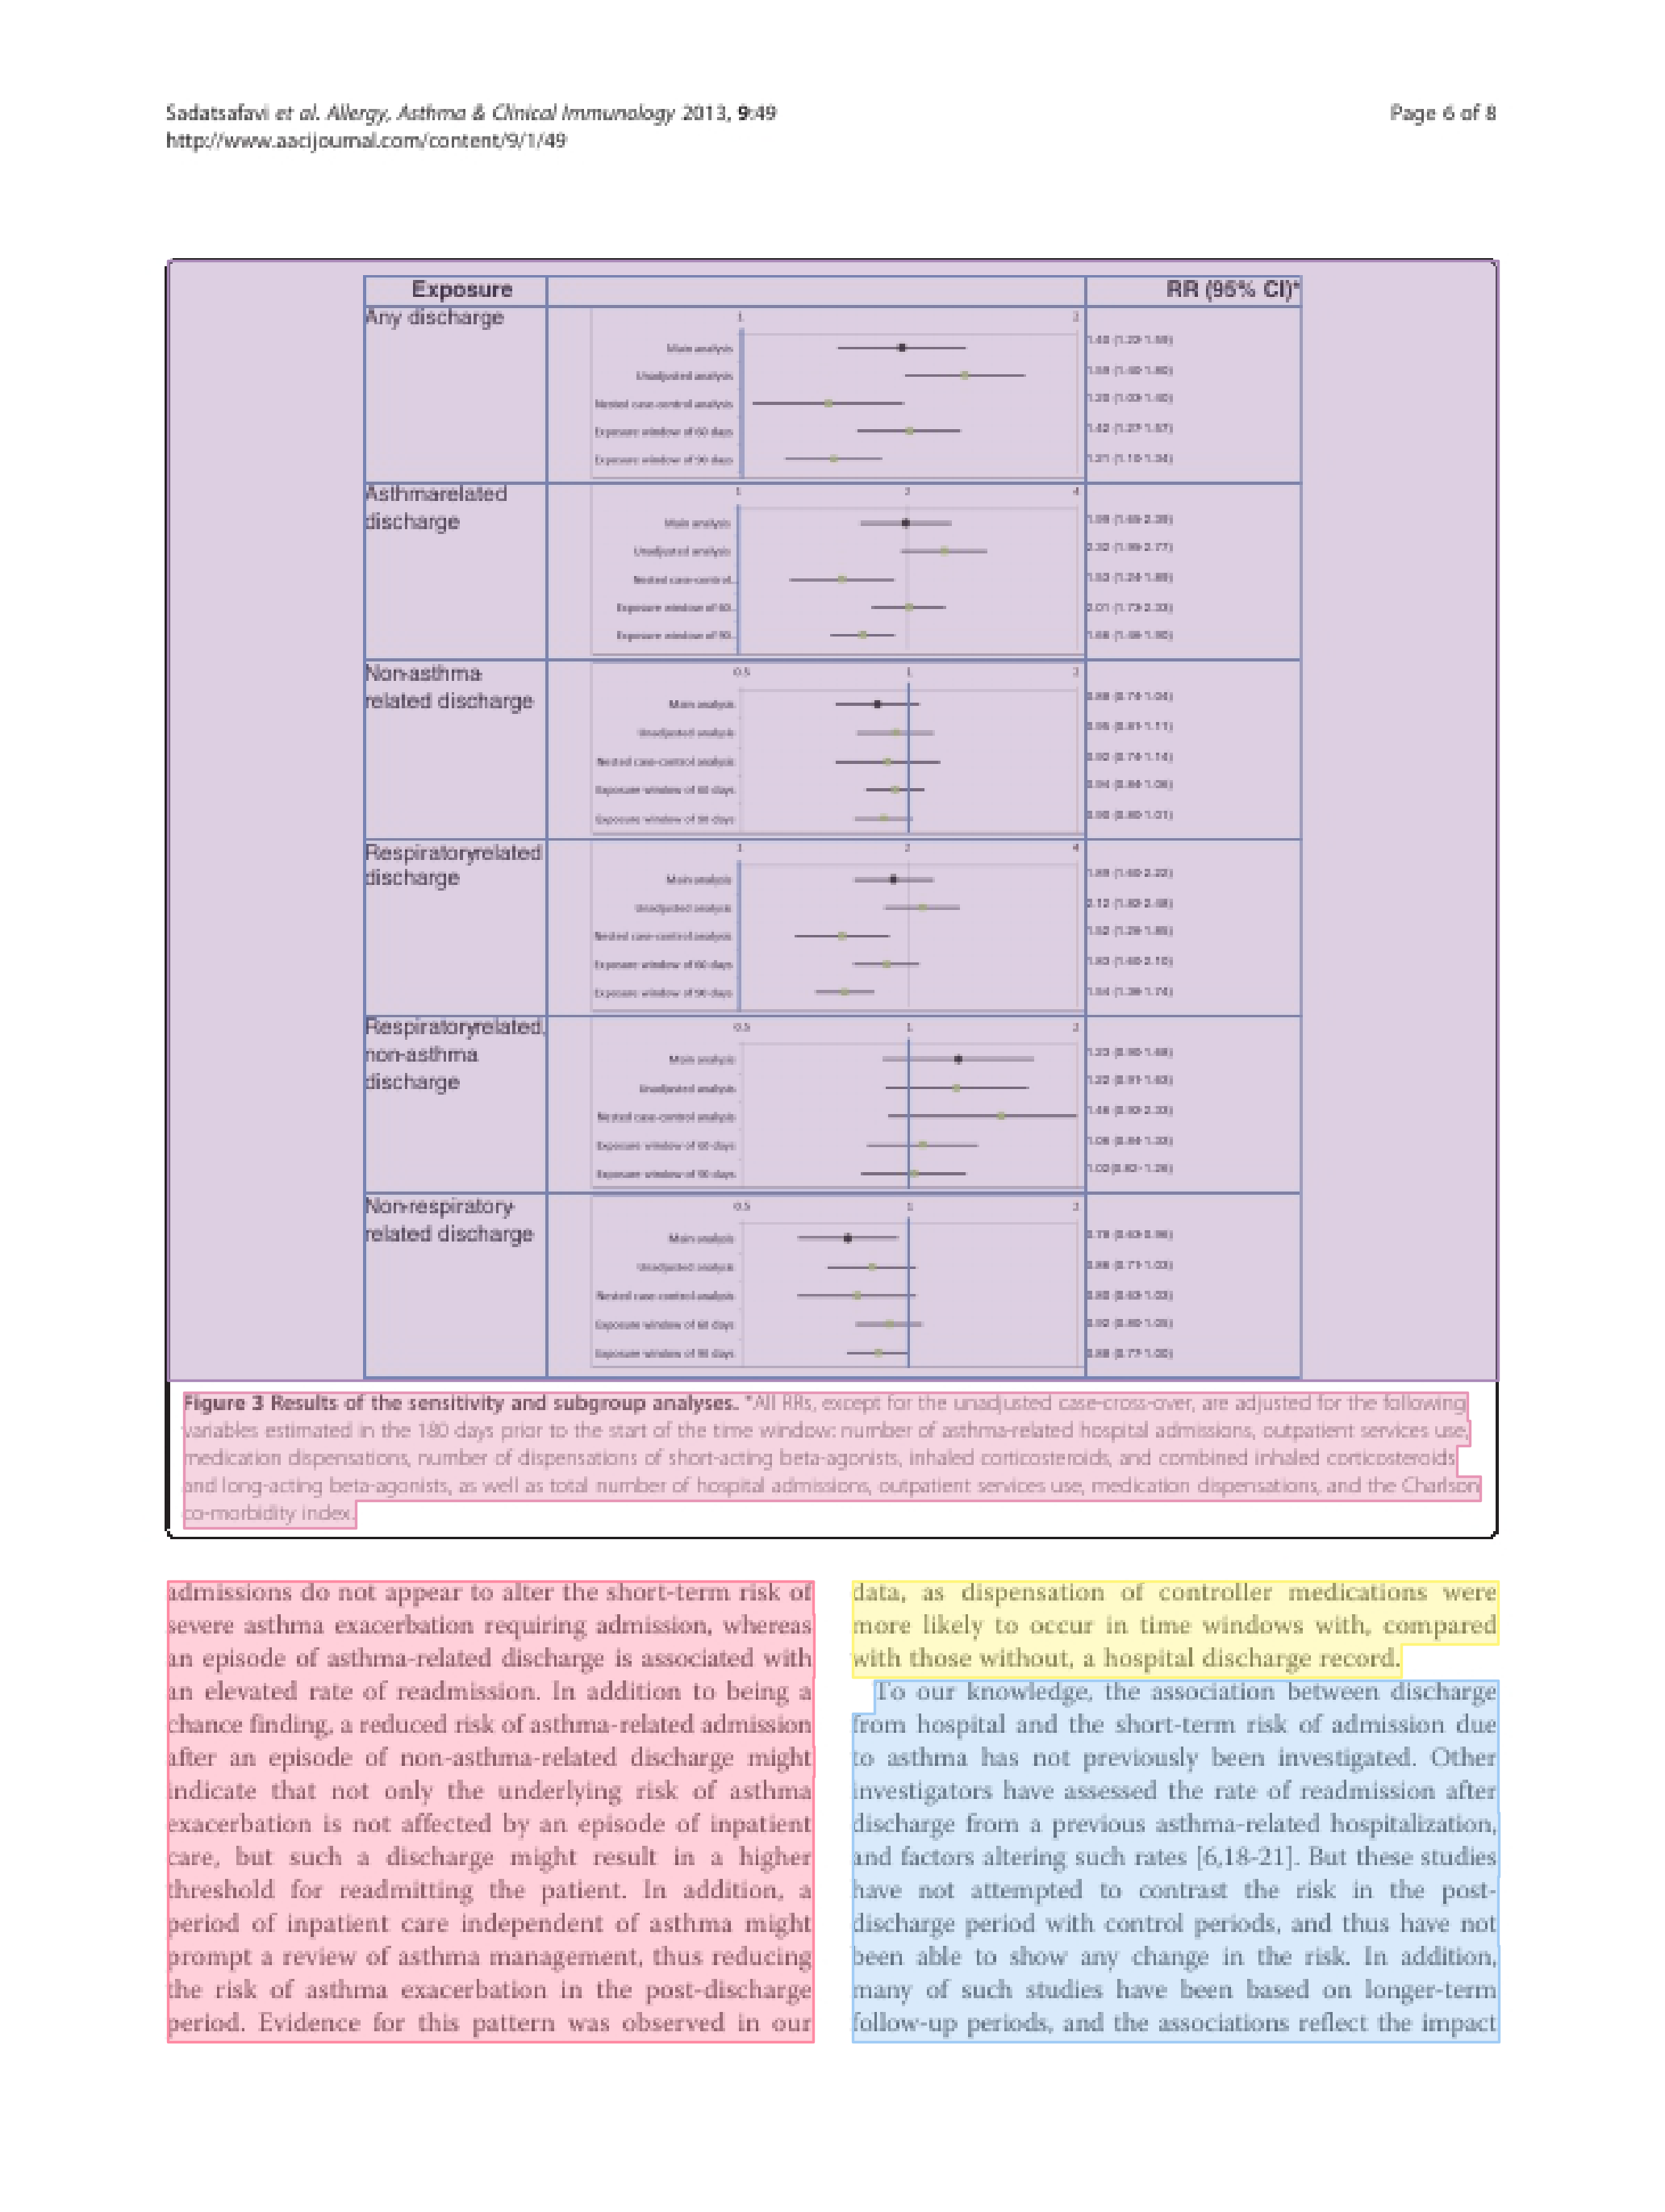

In [17]:
# load and display instance annotations
plt.figure(figsize=(30, 30), dpi=120)
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
h = I.shape[0]
w = I.shape[1]
print(anns)
for i in range(len(anns)):
    anns[i]['segmentation'][0] = np.array(anns[i]['segmentation'][0]) * np.array([w, h] * int(len(anns[i]['segmentation'][0])/2))
#print(anns[0])
#anns_new = np.array(anns[]) * np.array([h, w] * int(len(anns)/2))
coco.showAnns(anns)

In [18]:
print(anns)

[{'segmentation': [array([304.72, 568.5 , 538.54, 568.5 , 538.54, 580.52, 538.59, 580.52,
       538.59, 591.43, 503.54, 591.43, 503.54, 603.39, 304.72, 603.39,
       304.72, 592.48, 304.72, 580.52, 304.72, 568.5 ])], 'area': 7741.443669785978, 'iscrowd': 0, 'image_id': 372844, 'bbox': [0.511275167785235, 0.7159949622166247, 0.3923825503355705, 0.043954659949622166], 'category_id': 1, 'id': 3634000}, {'segmentation': [array([ 56.69, 568.5 , 290.49, 568.5 , 290.49, 580.52, 290.61, 580.52,
       290.61, 592.48, 290.62, 592.48, 290.62, 603.4 , 290.47, 603.4 ,
       290.47, 616.52, 290.52, 616.52, 290.52, 628.48, 290.62, 628.48,
       290.62, 639.4 , 290.52, 639.4 , 290.52, 652.52, 290.55, 652.52,
       290.55, 663.43, 290.5 , 663.43, 290.5 , 675.4 , 290.49, 675.4 ,
       290.49, 688.52, 290.56, 688.52, 290.56, 699.43, 290.54, 699.43,
       290.54, 711.39, 290.51, 711.39, 290.51, 724.51, 290.52, 724.51,
       290.52, 735.43,  56.69, 735.43,  56.69, 724.51,  56.69, 712.5 ,
        5

In [19]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
     |████████████████████████████████| 376 kB 61.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=aac3db032e055d8603f2cd5273ae6fef843a35e44c95d99d869443243d99aede
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2dc87527f125f350cbe51ddc7c28e563fd4ae3a30f426576a12477e85c47be5f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [20]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])

In [21]:
print(img)

[{'file_name': 'PMC3259476_00009.jpg', 'width': 601, 'id': 406876, 'height': 792}]


In [22]:
import glob
from pycocotools.coco import COCO
import more_itertools as mit

class LayoutDataset(Dataset):
    def __init__(self, root, transforms, json_file):
        super(LayoutDataset, self).__init__()
        self.root = root 
        self.catNms = ['text','figure']
        self.coco=COCO(os.path.join(root, json_file))
        self.catIds = self.coco.getCatIds(catNms=['text','figure']);
        imgIds = self.coco.getImgIds(catIds=self.catIds);
        self.imgs =  self.coco.loadImgs(imgIds)
        self.transforms = transforms
        self.json_file = json_file
  
    def __getitem__(self, idx):
        
        sample = {}
        img = self.imgs[idx]
        filename = os.path.join(self.root , "data/" + self.imgs[idx]['file_name'])
        #print(filename)
        #print(self.image_names[idx])
        image = cv2.imread(filename)
        # if image == None:
        #    print("None")
        #print(self.image_names[idx])
        #print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image)
        sample["image"] = image
        #print(image.shape)
        h = image.shape[0]
        w = image.shape[1]
        plt.imshow(image)
        plt.show()
        for s, catId in enumerate(self.catIds):
            annIds = self.coco.getAnnIds(imgIds=img['id'], catIds=[catId], iscrowd=None)
            anns = self.coco.loadAnns(annIds)
            h = image.shape[0]
            w = image.shape[1]
            #print(anns)
            mask = np.zeros(shape=image.shape[:2])
            for i in range(len(anns)):
                npoints = int(len(anns[i]['segmentation'][0])/2)
                if self.json_file == 'train.json':
                   poly = np.array(anns[i]['segmentation'][0]) * np.array([w, h] * npoints)
                else:
                   poly = np.array(anns[i]['segmentation'][0])  
                points = np.array(list((mit.chunked(poly, 2)))).astype(int)
                #points = np.array_split(poly, npoints)
                #print(points)
                #points = np.array([[1, 2], [3, 4]])
                cv2.fillConvexPoly(mask, points, 255)
            #plt.imshow(mask)
            #plt.show()
            mask = (mask.astype(np.float32)/255.0) > 0.5
            #plt.imshow(mask)
            #plt.show()
            if s == 0:
              masks = mask.reshape(1, h, w)
            else:
              masks = np.concatenate((masks, mask.reshape(1, h, w)), axis = 0)
            #cv2.imwrite( filename + "_" + self.catNms[s], mask)  
        
        sample['mask'] = masks
        sample['image'] = image
        if self.transforms is not None:
             sample = self.transforms(sample)
        # if self.transforms is not None:
        #     masks = masks.
        #     image, masks = self.transforms(image, masks) 
        #print(sample['image'].shape)
        #print(sample['masks'].shape)

       
        return sample['image'], sample['mask'], sample['image_cropped']
        #return image

    def __len__(self):
        return len(self.imgs)

In [23]:
CROP_SIZE = 256

In [24]:
class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        # self.size = torch.tensor(size, dtype=torch.float)
        self.size = np.asarray(size, dtype=np.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        masks_resized = []
        for i in range(2):
           mask = sample['mask'][i].astype('float32')
           #print(mask.shape)
           mask = cv2.resize(mask, None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
           masks_resized.append(mask)
        sample['mask'] = np.array(masks_resized)
        #print(sample['mask'].shape)   
        #sample["scale_coef"] = f

       

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample['mask'] = sample['mask'][:, margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        #print(sample['mask'].shape)
       # sample["crop_margin_x"] = margin_w
       # sample["crop_margin_y"] = margin_h
        sample['image_cropped'] = torch.LongTensor(sample[self.elem_name].copy())

    
        return sample
        
class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        #print(sample['mask'].shape)     
        #print(sample['image']) 
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])
        #print(sample['mask'].shape)     
        #print(sample['image'])      

        return sample

In [25]:
from torchvision import transforms
import albumentations


class apply_albumentations(object):
    def __init__(self, augmenter):
        self.augmenter = augmenter


    def __call__(self, sample):
        #print(sample)
        #print(self.augmenter)
        sample['image'] = self.augmenter(image=np.array(sample['image']))["image"]
        #plt.imshow(sample['image'])
        return sample

augmenter = albumentations.Compose([
    albumentations.ShiftScaleRotate(rotate_limit=90, p=0.7),
    albumentations.RandomBrightnessContrast(p=0.4),
    albumentations.RandomGamma(p=0.4),
    albumentations.Blur(blur_limit=2, p=0.1),
    albumentations.GaussNoise((10, 100), p=0.2),
    albumentations.HorizontalFlip(p=0.5)
])


train_transforms = transforms.Compose([
        #apply_albumentations(augmenter),                                
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        #TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),#
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",))
])

val_transforms = transforms.Compose([
                                
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        #TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),#
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",))
])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [26]:
#from torchvision.models.segmentation import deeplabv3_resnet50
#from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights
import segmentation_models_pytorch as smp
def get_model():
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    # model.aux_classifier = nn.Sequential(nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    #                                nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    #                                nn.ReLU(),
    #                                nn.Dropout(p=0.1, inplace=False), 
    #                                nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    #                                )
   

    # weights = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
    # weights_backbone = ResNet50_Weights.DEFAULT 
    # model = deeplabv3_resnet50(weights=weights, progress=False, num_classes = 2, weights_backbone = weights_backbone)

    model = smp.DeepLabV3(encoder_name='resnet50', encoder_depth=5, encoder_weights='imagenet', decoder_channels=256, in_channels=3, classes=2, activation=None, upsampling=8, aux_params=None) 
    #torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    return model

In [27]:

def dice_coeff(input, target):
    smooth = 1.

    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    union = input_flat.sum() + target_flat.sum()

    return (2. * intersection + smooth) / (union + smooth)


def dice_loss(input, target):
    # TODO TIP: Optimizing the Dice Loss usually helps segmentation a lot.
    return - torch.log(dice_coeff(input, target))

In [28]:

import logging
import cv2
import numpy as np
import torch


def get_logger(filename: str) -> logging.Logger:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s %(message)s', '%Y-%m-%d %H:%M:%S')
    fh = logging.FileHandler(filename)
    fh.setLevel(logging.INFO)
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    sh = logging.StreamHandler()
    sh.setLevel(logging.INFO)
    sh.setFormatter(formatter)
    logger.addHandler(sh)
    return logger




In [29]:

#from segmentation.dataset import DetectionDataset
#from segmentation.loss import dice_coeff, dice_loss
#from segmentation.models import get_model
#from segmentation.transforms import get_train_transforms, get_val_transforms
#from inference_utils import get_logger
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#os.chdir("/content/")




#def parse_arguments():
    #parser = ArgumentParser()
    #parser.add_argument("-d", "--data_path", dest="data_path", type=str, default=None, help="path to the data")
    #parser.add_argument("-e", "--epochs", dest="epochs", default=10, type=int, help="number of epochs")
    #parser.add_argument("-b", "--batch_size", dest="batch_size", default=80, type=int, help="batch size")
    #parser.add_argument("-s", "--image_size", dest="image_size", default=256, type=int, help="input image size")
    #parser.add_argument("-lr", "--learning_rate", dest="lr", default=3e-4, type=float, help="learning rate")
    #parser.add_argument("-wd", "--weight_decay", dest="weight_decay", default=1e-6, type=float, help="weight decay")
    #parser.add_argument("-lrs", "--learning_rate_step", dest="lr_step", default=None, type=int, help="learning rate step")
    #parser.add_argument("-lrg", "--learning_rate_gamma", dest="lr_gamma", default=None, type=float,
    #                    help="learning rate gamma")
    #parser.add_argument("-w", "--weight_bce", default=1, type=float, help="weight for BCE loss")
    #parser.add_argument("-l", "--load", dest="load", default=None, help="load file model")
    #parser.add_argument("-o", "--output_dir", dest="output_dir", default="runs/segmentation_baseline",
    #                    help="dir to save log and models")

    #return parser.parse_args()


def validate(model, val_dataloader, device):
    model.eval().to(device)
    val_dice = []
    for batch in tqdm(val_dataloader):
        images, true_masks, _ = batch
        with torch.no_grad():
            masks_pred = model(images.to(device)).squeeze(1)  # (b, 1, h, w) -> (b, h, w)
        masks_pred = (torch.sigmoid(masks_pred) > 0.5).float() #* 255
        # print(masks_pred.cpu().shape)
        # plt.imshow( masks_pred.cpu()[0][0] * 255)
        # plt.show()
        # plt.imshow( true_masks[0][0] * 255)
        # plt.show()
        # plt.imshow( masks_pred.cpu()[0][1] * 255)
        # plt.show()
        # plt.imshow( true_masks[0][1] * 255)
        # plt.show()
        dice = dice_coeff(masks_pred.cpu(), true_masks).item()
        val_dice.append(dice)
        #break
    return np.mean(val_dice)


def train(model, optimizer, criterion, scheduler, train_dataloader, logger, device=None):
    model.train()

    epoch_losses = []
    epoch_bce_losses, epoch_dice_losses = [], []

    history = []
    tqdm_iter = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, batch in tqdm_iter:
        imgs, true_masks, _ = batch
        #print(imgs.shape)
        #print(true_masks.shape)
        masks_pred = model(imgs.to(device))
        #print(masks_pred)
        #masks_probs = torch.sigmoid(masks_pred['out'])
        masks_probs = torch.sigmoid(masks_pred)
        #print(masks_probs.shape)
        #print(true_masks.shape)

        bce_loss_value, dice_loss_value = criterion(masks_probs.cpu().view(-1), true_masks.view(-1))
        loss = bce_loss_value + dice_loss_value

        #print(loss.cpu())
        epoch_bce_losses.append(bce_loss_value.item())
        epoch_dice_losses.append(dice_loss_value.item())
        epoch_losses.append(loss.item())
        tqdm_iter.set_description(f"mean loss: {np.mean(epoch_losses):.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if scheduler is not None:
            scheduler.step(loss.item())

        history.append(loss.cpu().data.numpy())
        #break
        # if (i+1)%5==0:
        #     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        #     clear_output(True)
        #     ax[0].plot(history, label='train loss')
        #     ax[0].set_xlabel('Batch')
        #     ax[0].set_title('Train loss')
        #     #if train_history is not None:
        #     #    ax[1].plot(train_history, label='general train history')
        #     #    ax[1].set_xlabel('Epoch')
        #     #if valid_history is not None:
        #     #    ax[1].plot(valid_history, label='general valid history')
        #     plt.legend()
          
        #     plt.show()
        


    logger.info(
        f"Epoch finished! Loss: {np.mean(epoch_losses):.5f} ({np.mean(epoch_bce_losses):.5f} | {np.mean(epoch_dice_losses):.5f})")
    

        

    return np.mean(epoch_losses)


   

In [30]:
# @title
# import cv2
# import numpy as np


# class Compose(object):

#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, mask):
#         for t in self.transforms:
#             image, mask = t(image, mask)
#         return image, mask


# class Pad(object):

#     def __init__(self, max_size=1.0, p=0.1):
#         self.max_size = max_size
#         self.p = p

#     def __call__(self, image, mask):
#         if np.random.uniform(0.0, 1.0) > self.p:
#             return image, mask
#         h, w, _ = image.shape
#         size = int(np.random.uniform(0, self.max_size) * min(w, h))
#         image_ = cv2.copyMakeBorder(image, size, size, size, size, borderType=cv2.BORDER_CONSTANT, value=0.0)
#         mask_ = cv2.copyMakeBorder(mask, size, size, size, size, borderType=cv2.BORDER_CONSTANT, value=0.0)
#         return image_, mask_


# class Crop(object):
#     def __init__(self, min_size=0.5, min_ratio=0.5, max_ratio=2.0, p=0.25):
#         self.min_size = min_size
#         self.min_ratio = min_ratio
#         self.max_ratio = max_ratio
#         self.p = p

#     def __call__(self, image, mask):
#         if np.random.uniform(0.0, 1.0) > self.p:
#             return image, mask
#         h, w, _ = image.shape
#         aspect_ratio = np.random.uniform(self.min_ratio, self.max_ratio)  # = w / h
#         if aspect_ratio > 1:
#             w_ = int(np.random.uniform(self.min_size, 1.0) * w)
#             h_ = int(w / aspect_ratio)
#         else:
#             h_ = int(np.random.uniform(self.min_size, 1.0) * h)
#             w_ = int(h * aspect_ratio)

#         x = np.random.randint(0, max(1, w - w_))
#         y = np.random.randint(0, max(1, h - h_))
#         crop_image = image[y: y + h_, x: x + w_, :]
#         crop_mask = mask[y: y + h_, x: x + w_]
#         return crop_image, crop_mask


# class Resize(object):
#     def __init__(self, size, keep_aspect=False):
#         self.size = size
#         self.keep_aspect = keep_aspect

#     def __call__(self, image, mask):
#         image_, mask_ = image.copy(), mask.copy()
#         if self.keep_aspect:
#             # padding step
#             h, w = image.shape[:2]
#             k = min(self.size[0] / w, self.size[1] / h)
#             h_ = int(h * k)
#             w_ = int(w * k)

#             interpolation = cv2.INTER_AREA if k <= 1 else cv2.INTER_LINEAR
#             image_ = cv2.resize(image_, None, fx=k, fy=k, interpolation=interpolation)
#             mask_ = cv2.resize(mask_, None, fx=k, fy=k, interpolation=interpolation)

#             dh = max(0, (self.size[1] - h_) // 2)
#             dw = max(0, (self.size[0] - w_) // 2)
#             image_ = cv2.copyMakeBorder(image_, dh, dh, dw, dw, cv2.BORDER_CONSTANT, value=0.0)
#             mask_ = cv2.copyMakeBorder(mask_, dh, dh, dw, dw, cv2.BORDER_CONSTANT, value=0.0)
#         if image_.shape[0] != self.size[1] or image_.shape[1] != self.size[0]:
#             image_ = cv2.resize(image_, self.size)
#             mask_ = cv2.resize(mask_, self.size)
#         return image_, mask_


# class Flip(object):
#     def __init__(self, p=0.1):
#         self.p = p

#     def __call__(self, image, mask):
#         if np.random.uniform() > self.p:
#             return image, mask
#         return cv2.flip(image, 1), cv2.flip(mask, 1)


# class Normalize(object):
#     def __init__(self, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
#         self.mean = np.asarray(mean).reshape((1, 1, 3)).astype(np.float32)
#         self.std = np.asarray(std).reshape((1, 1, 3)).astype(np.float32)

#     def __call__(self, image, mask):
#         image = (image - self.mean) / self.std
#         return image, mask


# # TODO TIP: Is default image size (256) enough for segmentation of car license plates?
# # TODO TIP: Chances are there's a great lib for complex data augmentations, 'Albumentations' or so...
# # TODO TIP: Keywords to think about: 'class imbalance', 'lack of data'.
# def get_train_transforms(image_size):
#     return Compose([
#         Normalize(),
#         Crop(min_size=1 - 1 / 3., min_ratio=1.0, max_ratio=1.0, p=0.5),
#         Flip(p=0.05),
#         Pad(max_size=0.6, p=0.25),
#         Resize(size=(image_size, image_size), keep_aspect=True)
#     ])


# def get_val_transforms(image_size):
#     return Compose([
#         Normalize(),
#         Resize(size=(image_size, image_size))
#     ])

In [31]:
os.makedirs(args.output_dir, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logger = get_logger(os.path.join(args.output_dir, "train.log"))
logger.info("Start training with params:")
for arg, value in sorted(vars(args).items()):
    logger.info("Argument %s: %r", arg, value)

# TODO TIP: Try other models, either from smp package or from somewhere else.
model = get_model()
print(model)
if args.load is not None:
    with open(args.load, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)
model.to(device)
logger.info(f"Model type: {model.__class__.__name__}")

# TODO TIP: Pure Adam(W) with Karpathy constant LR is great, but there's still room for improvements.
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# TODO TIP: You can always try on plateau scheduler as a default option
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_step, gamma=args.lr_gamma) \
#    if args.lr_step is not None else None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# TODO TIP: Remember what are the problems of BCE for semantic segmentation?
# Key words: 'background'.
criterion = lambda x, y: (args.weight_bce * nn.BCELoss()(x, y), (1. - args.weight_bce) * dice_loss(x, y))

#train_transforms = get_train_transforms(args.image_size)
#val_transforms = get_val_transforms(args.image_size)

train_dataset = LayoutDataset('/content/datadir/',  train_transforms, "train.json")
val_dataset = LayoutDataset('/content/datadir/', val_transforms, "test.json")
# train_dataset = DetectionDataset(args.data_path, os.path.join(args.data_path, "train_segmentation.json"),
#                                   transforms=train_transforms, split="train")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True,worker_init_fn=seed_worker,   generator=g,)

# val_transforms = get_val_transforms(args.image_size)
# val_dataset = DetectionDataset(args.data_path, os.path.join(args.data_path, "train_segmentation.json"),
#                                 transforms=val_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                            pin_memory=True, shuffle=False, drop_last=False, worker_init_fn=seed_worker,   generator=g,)

logger.info(f"Length of train / val = {len(train_dataset)} / {len(val_dataset)}")
logger.info(f"Number of batches of train / val = {len(train_dataloader)} / {len(val_dataloader)}")

best_model_info = {"epoch": -1, "val_dice": 0., "train_dice": 0., "train_loss": 0.}




2022-04-29 11:32:49 Start training with params:
2022-04-29 11:32:49 Argument batch_size: 16
2022-04-29 11:32:49 Argument data_dir: './data_preprocessed_python/'
2022-04-29 11:32:49 Argument data_path: '/content/drive/MyDrive/MADE/semester2/CV/contest02/data/'
2022-04-29 11:32:49 Argument epochs: 2
2022-04-29 11:32:49 Argument gpu: True
2022-04-29 11:32:49 Argument image_size: 256
2022-04-29 11:32:49 Argument learning_rate: 0.001
2022-04-29 11:32:49 Argument learning_rate_gamma: None
2022-04-29 11:32:49 Argument load: None
2022-04-29 11:32:49 Argument lr: 0.0003
2022-04-29 11:32:49 Argument output_dir: '/content/drive/MyDrive/MADE/Project/RACNN_models/'
2022-04-29 11:32:49 Argument weight_bce: 0.5
2022-04-29 11:32:49 Argument weight_decay: 1e-06
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

2022-04-29 11:33:03 Model type: DeepLabV3
2022-04-29 11:33:03 Length of train / val = 859 / 170
2022-04-29 11:33:03 Number of batches of train / val = 53 / 11


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [32]:
args.epochs = 1
for epoch in range(args.epochs):
    logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")

    train_loss = train(model, optimizer, criterion, scheduler, train_dataloader, logger, device)
    print(train_loss)
    val_dice = validate(model, val_dataloader, device)
    print(val_dice)
    if val_dice > best_model_info["val_dice"]:
        best_model_info["val_dice"] = val_dice
        best_model_info["train_loss"] = train_loss
        best_model_info["epoch"] = epoch
        with open(os.path.join(args.output_dir, "CP-best_seg.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)
        logger.info(f"Validation Dice Coeff: {val_dice:.3f} (best)")
    else:
        logger.info(f"Validation Dice Coeff: {val_dice:.5f} (best {best_model_info['val_dice']:.5f})")

with open(os.path.join(args.output_dir, "CP-last_seg.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)



2022-04-29 11:33:03 Starting epoch 1/1.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-04-29 11:36:00 Epoch finished! Loss: 0.20792 (0.10550 | 0.10242)


0.20791576493461178


  0%|          | 0/11 [00:00<?, ?it/s]

0.9361622170968489


2022-04-29 11:36:33 Validation Dice Coeff: 0.936 (best)


In [33]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
args.epochs = 5
for epoch in range(args.epochs):
    logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")

    train_loss = train(model, optimizer, criterion, scheduler, train_dataloader, logger, device)
    print(train_loss)
    val_dice = validate(model, val_dataloader, device)
    print(val_dice)
    if val_dice > best_model_info["val_dice"]:
        best_model_info["val_dice"] = val_dice
        best_model_info["train_loss"] = train_loss
        best_model_info["epoch"] = epoch
        with open(os.path.join(args.output_dir, "CP-best_seg.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)
        logger.info(f"Validation Dice Coeff: {val_dice:.3f} (best)")
    else:
        logger.info(f"Validation Dice Coeff: {val_dice:.5f} (best {best_model_info['val_dice']:.5f})")


2022-04-29 11:36:34 Starting epoch 1/5.


  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", f"deap95.pt")
            )   

In [ ]:
with open(os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", "best_seg.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)

In [ ]:
val_dice = validate(model, val_dataloader, device)

In [ ]:
print(val_dice)

In [ ]:
val_dataset = LayoutDataset('/content/datadir/', val_transforms, "test.json")

val_dataset.__getitem__(20)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                            pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
model = get_model()
model_state  = torch.load( os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", f"CP-best_seg.pth"))

model.load_state_dict(model_state)

In [ ]:
val_dice = validate(model, val_dataloader, device)

In [ ]:
print(val_dice)

  0%|          | 0/53 [00:00<?, ?it/s]

torch.Size([16, 256, 256, 3])


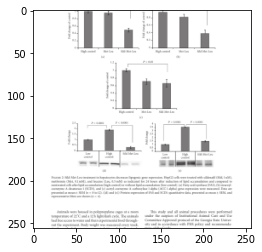

In [34]:
history = []
tqdm_iter = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
for i, batch in tqdm_iter:
     imgs, true_masks, image_cropped = batch
     print(image_cropped.shape)
     plt.imshow(image_cropped[0])
     plt.show()
     break


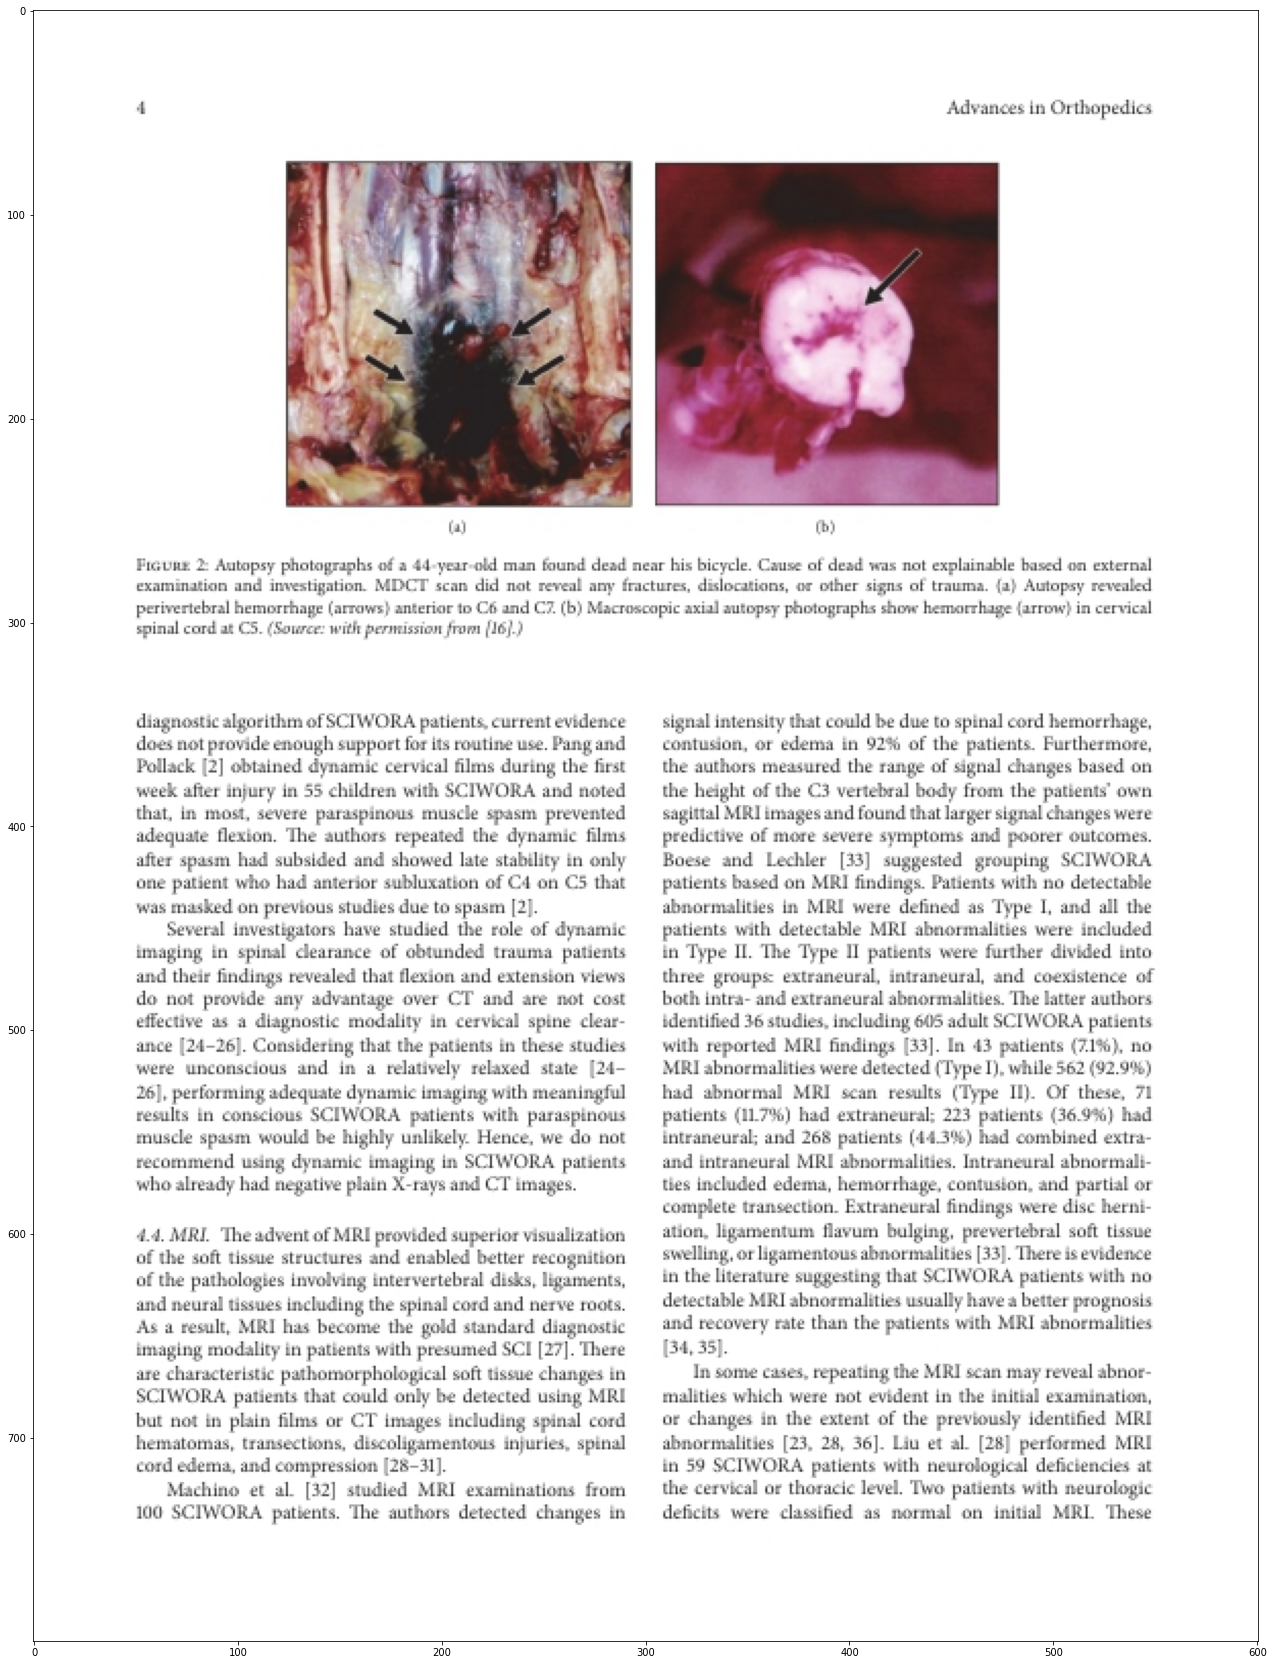

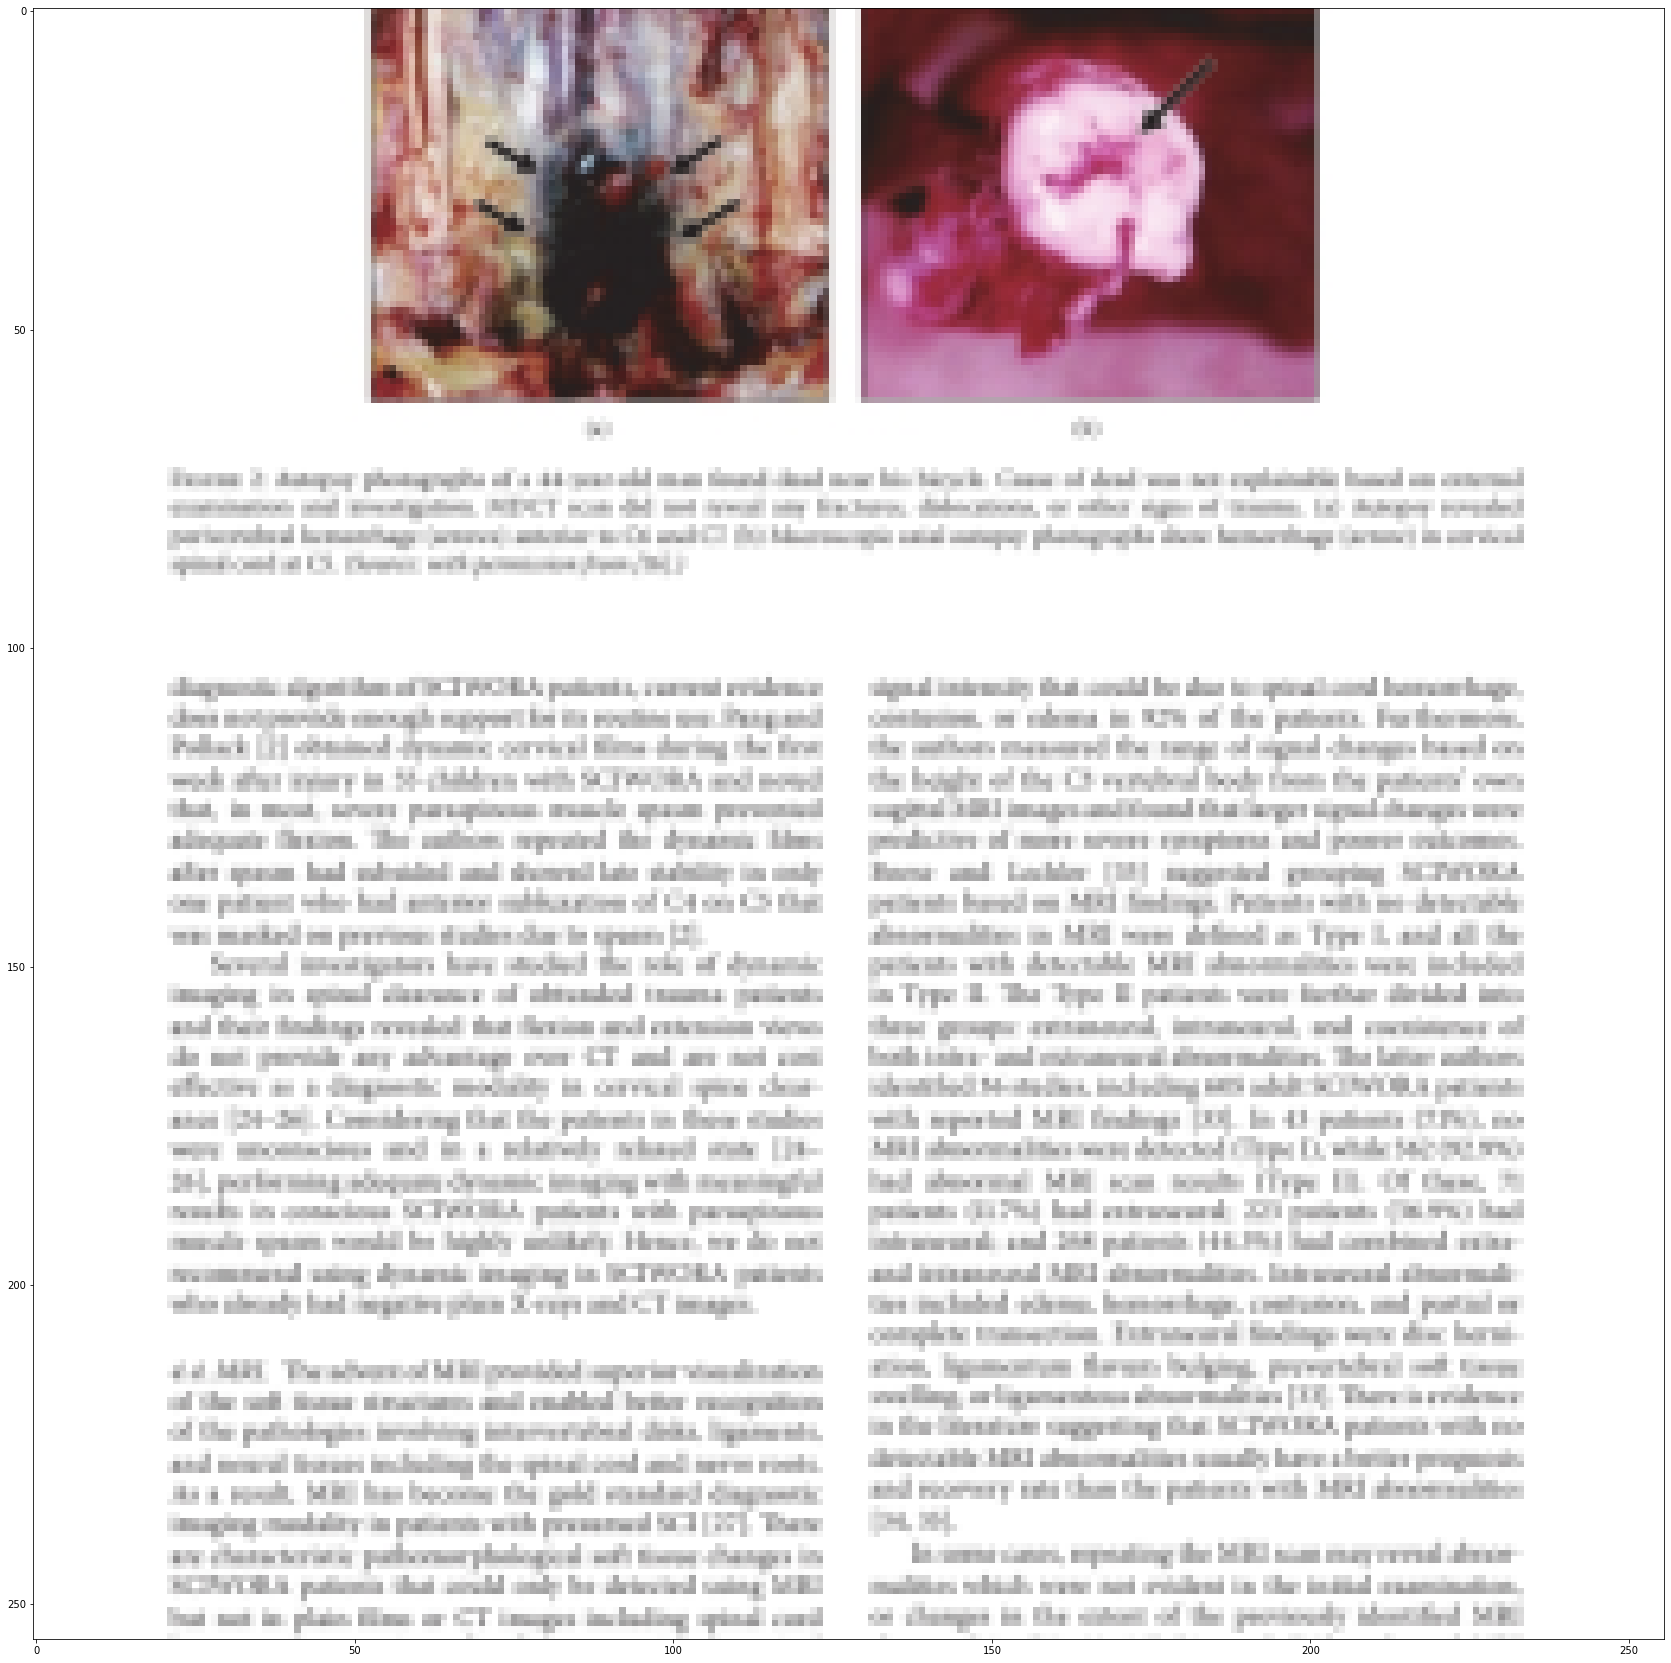

In [35]:
plt.figure(figsize=(30, 30))
image, mask, cropped= train_dataset.__getitem__(20)
plt.figure(figsize=(30, 30))
plt.imshow(cropped)
plt.show()